In [1]:
import os, sys

In [15]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import integrate
from omfit_classes import omfit_eqdsk
from omfit_classes import utils_fusion
import matplotlib
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator
%matplotlib inline

In [16]:
#constant parameters
clight = 3e8 #m/s
gfile = omfit_eqdsk.OMFITgeqdsk('gNARC_k14d05R455a120')#'gNTARC_iter1_small_pedestal_n_17')
print(gfile.keys())
R_0 = gfile['RCENTR']
psin = gfile['fluxSurfaces']['geo']['psin']
#print(gfile['fluxSurfaces']['geo'].keys())

print(gfile['AuxQuantities'].keys())

ModuleNotFoundError: No module named 'matplotlib._contour'

In [6]:
#constant parameters
clight = 3e8 #m/s

# class in which the tokamamk information is stored
class tokamak():
    #this class contains information on the equilibrium geometry and the
    #tokamak profiles. tokamak profiles can be assigned with either a file
    #containing the profile data (not yet implemented) or parabolic profiles
    
    def __init__(self):
        #name and eqdskfile
        self.machinename='manta'
        self.eqdsk_name ='gNTARC_iter1_small_pedestal_n_17'#'gNTARC_iter1_Stuart'#'GARC_4.55R_1.2a_updatedProfiles_altgeqdsk'

        #profiles
        self.prof_type = 'parab'

        # temperature [keV]
        self.Te_0 = 24.97
        self.Te_sep = 0.553
        self.Te_alpha1 = 1.4848
        self.Te_alpha2 = 1.1313

        self.Ti_0 = 24.97
        self.Ti_sep = 0.553
        self.Ti_alpha1 = 1.4848
        self.Ti_alpha2 = 1.1313

        #density [10^20 m^-3]
        self.n_0 = 2.87
        self.n_sep = 0.95
        self.n_alpha1 = 2.1212
        self.n_alpha2 = 1.6154

        self.Mi = 2.5

    #initializes geometry and flux grid
    def get_eqdsk_info(self):
        gfile = omfit_eqdsk.OMFITgeqdsk(self.eqdsk_name)
        self.gfile = gfile
        #get sq_psi_n grid (maybe add other grid options in future?)
        psin = gfile['fluxSurfaces']['geo']['psin']
        #gfile.plot()
        sqpsin = np.sqrt(psin)
        self.rho = sqpsin
        self.N_rho = len(sqpsin)
        self.fluxSurfaceAvgr = gfile['fluxSurfaces']['geo']['rho']#['fluxSurfaces']['geo']['a']
        self.fluxSurfaceAvgr[0] = np.min(gfile['fluxSurfaces']['geo']['a'])

        #get a (at the midplane) and R_0
        rminn = gfile['fluxSurfaces']['geo']['a']
        self.a = rminn[-1]
        self.R_0 = gfile['RCENTR']

        #areas and volumes
        self.area_surf = gfile['fluxSurfaces']['geo']['surfArea']
        self.area_cross = gfile['fluxSurfaces']['geo']['cxArea']
        self.vol = gfile['fluxSurfaces']['geo']['vol']
        
        #B-field
        self.B_0 = gfile['BCENTR']

        #current
        self.I_p = gfile['CURRENT']/1.0e6
        self.J_tavg = (gfile['fluxSurfaces']['avg']['Jt'])
        
        self.q_prof = gfile['QPSI']  #safety factor profile (N_rho long)
        self.pressure_prof = gfile['PRES'] #pressure profile

        self.rlim = gfile["RLIM"] #R points of the wall
        self.zlim = gfile["ZLIM"] #Z points of the wall
        self.rbbbs = gfile["RBBBS"] #R points of the LCFS
        self.zbbbs = gfile["ZBBBS"] # Z points of the LCFS       
                

        

    #helper routine for init_profs
    def __f_parab(self,A_0,A_s,a_1,a_2,x):
        return (A_0 - A_s)*(1-x**a_1)**a_2 + A_s
    
    #lets user use trinity profiles
    def set_trinity_Te_prof(self, trinity_Te_profile):
        self.trinity_Te_profile = trinity_Te_profile

    #intializes T,n,eta profiles
    def init_profs(self, filename=''):
        gfile = omfit_eqdsk.OMFITgeqdsk(self.eqdsk_name)
        if self.prof_type == 'parab':
            self.Te_prof = self.__f_parab(self.Te_0,self.Te_sep,self.Te_alpha1,\
                                     self.Te_alpha2,self.rho)
            self.Ti_prof = self.__f_parab(self.Ti_0,self.Ti_sep,self.Ti_alpha1,\
                                     self.Ti_alpha2,self.rho)
            self.n_prof = self.__f_parab(self.n_0,self.n_sep,self.n_alpha1,self.\
                                    n_alpha2,self.rho)

            self.Zeff_prof = 2 + np.zeros(len(self.Te_prof))

            #neoclassical conductivity profile
            self.neoclass_conductivity_prof = utils_fusion.nclass_conductivity_from_gfile(gEQDSK = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff', Zis = [2])[0]
            #flux averaged bootstrap current profile
            self.J_BS_prof = utils_fusion.sauter_bootstrap(gEQDSKs = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, 
                                                        Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),
                                                        charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff',
                                                        Zis = [2], R0 = self.R_0, p = np.array([self.pressure_prof]), version = 'osborne')[0]
            #there are some divide by zeros in the above calculation, so this smooths that over. Bandaid fix.
            self.J_BS_prof[np.isnan(self.J_BS_prof)] = 0; self.J_BS_prof[self.J_BS_prof == np.inf] = 0

            #neoclassical resistivity profile
            self.neoEta_prof = utils_fusion.eta_par_neo(zeff = self.Zeff_prof, te = self.Te_prof*1e3, 
                ne = self.n_prof*1e20, q = self.q_prof, R0 = (self.R_0 + np.zeros(len(self.Te_prof))), rho = self.fluxSurfaceAvgr)


            """
            fig,ax = plt.subplots()
            ax.plot(self.rho, self.J_BS_prof, label = 'BS')
            ax.plot(self.rho, self.J_tavg, label = 'flux avg J')
            ax.legend()
            plt.show()
            """

            """
            fig,ax = plt.subplots()
            ax.plot(self.rho, self.Te_prof*1e3, label = "Te prof",color ='r')
            ax1= ax.twinx()
            ax1.plot(self.rho, self.n_prof*1e20, label = "ne prof", color = 'b')
            ax.legend()
            ax1.legend()
            plt.show()
            """
        
        elif self.prof_type == 'trinity':
            print('TRINITY CALLED')
            self.Te_prof = self.trinity_Te_profile  # set the Te profile from trinity 
            self.Ti_prof = self.__f_parab(self.Ti_0,self.Ti_sep,self.Ti_alpha1,\
                                     self.Ti_alpha2,self.rho)
            self.n_prof = self.__f_parab(self.n_0,self.n_sep,self.n_alpha1,self.\
                                    n_alpha2,self.rho)

            self.Zeff_prof = 2 + np.zeros(len(self.Te_prof))

            #neoclassical conductivity profile
            self.neoclass_conductivity_prof = utils_fusion.nclass_conductivity_from_gfile(gEQDSK = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff', Zis = [2])[0]
            #flux averaged bootstrap current profile
            self.J_BS_prof = utils_fusion.sauter_bootstrap(gEQDSKs = gfile, Zeff = np.array([self.Zeff_prof]), psi_N = self.rho**2, 
                                                        Ti = np.array([self.Ti_prof*1e3]), ne = np.array([self.n_prof*1e20]), Te = np.array([self.Te_prof*1e3]),
                                                        charge_number_to_use_in_ion_collisionality = 'Zeff', charge_number_to_use_in_ion_lnLambda = 'Zeff',
                                                        Zis = [2], R0 = self.R_0, p = np.array([self.pressure_prof]), version = 'osborne')[0]
            #there are some divide by zeros in the above calculation, so this smooths that over. Bandaid fix.
            self.J_BS_prof[np.isnan(self.J_BS_prof)] = 0; self.J_BS_prof[self.J_BS_prof == np.inf] = 0

            #neoclassical resistivity profile
            self.neoEta_prof = utils_fusion.eta_par_neo(zeff = self.Zeff_prof, te = self.Te_prof*1e3, 
                ne = self.n_prof*1e20, q = self.q_prof, R0 = (self.R_0 + np.zeros(len(self.Te_prof))), rho = self.fluxSurfaceAvgr)
        else:
            raise Exception('no other prof_types supported rn')
        
    def get_Te_from_J(self, J_rho):
        R0 = self.R_0
        rho = self.rho
        a = self.a
        if len(J_rho) != len(rho):
            raise ValueError(f'Array length error. Length of J_rho = {len(J_rho)},\
                             length of rho = {len(rho)}')
        r_array = rho*a
        neoEta = self.neoEta_prof  
        # Find integration constant to conserve the Ip total current. Note chease redoes this so
        # this is not actually critical for the output profile. 
        C = self.gfile['CURRENT']/integrate.cumtrapz((1/(neoEta*R_0)), self.area_cross)[-1]
        
        R = R = self.gfile['fluxSurfaces']['geo']['R'] 
        
        return ((3.3e-8)*(R/C)*(1 - (r_array/R0)**0.5)**(-2)*J_rho)**(2/3)
        
        
        
        
        

In [8]:
%matplotlib inline

In [9]:
# read in Haley's arrays 
def haleyloader(filepath):
    with open(filepath,'r') as f:
        datastr = f.read()
    cleandatastr = datastr.replace('\n','')
    return np.fromstring(cleandatastr,sep=' ')

ne_Hal = np.loadtxt('highnsep_ne_haley.txt')
ne_Hal = ne_Hal.flatten()[:-4]

ni_Hal = np.loadtxt('highnsep_ni_haley.txt')
ni_Hal = ne_Hal.flatten()[:-4]

ne_Hal = ne_Hal/1e20
ni_Hal = ni_Hal/1e20

Ti_Hal = np.loadtxt('highnsep_Ti_haley.txt')
Ti_Hal = Ti_Hal.flatten()[:-1]/1000

Te_Hal = np.loadtxt('highnsep_Te_haley.txt')
Te_Hal = Te_Hal.flatten()[:-1]/1000

rho_Hal_T = np.linspace(0, 0.8, len(Te_Hal))
rho_Hal_ni = np.linspace(0, 0.8, len(ni_Hal))
rho_Hal_ne = np.linspace(0, 0.8, len(ne_Hal))

get_Hal_ne = PchipInterpolator(rho_Hal_ne, ne_Hal)
get_Hal_ni = PchipInterpolator(rho_Hal_ni, ni_Hal)
get_Hal_Te = PchipInterpolator(rho_Hal_T, Te_Hal)
get_Hal_Ti = PchipInterpolator(rho_Hal_T, Ti_Hal)


print(ni_Hal.shape)
print(len(ne_Hal))

(157,)
161


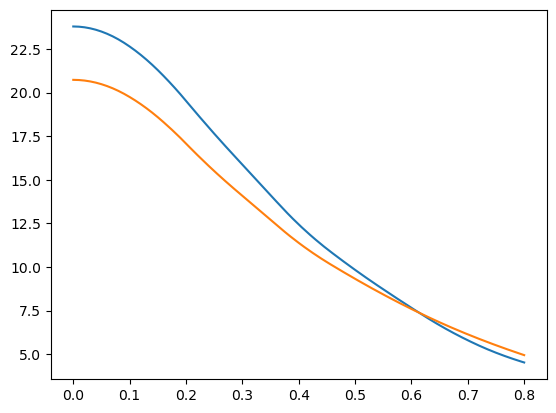

In [10]:
plt.plot(rho_Hal_T, Te_Hal)
plt.plot(rho_Hal_T, Ti_Hal)

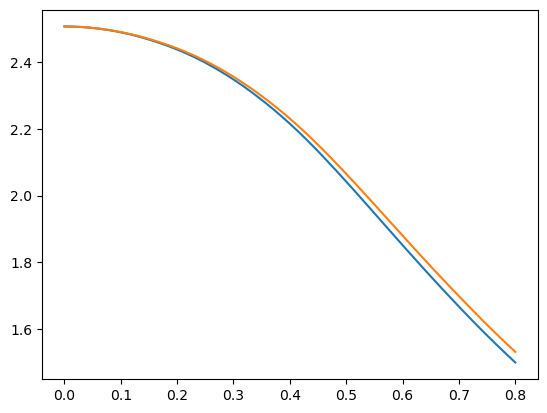

In [11]:


plt.plot(rho_Hal_ne, ne_Hal)
plt.plot(rho_Hal_ni, ni_Hal)

In [12]:
# Haley Cell 
def convert(rho1,rho2,prof1):
    prof1fun = PchipInterpolator(rho1,prof1)
    rhoconvfun = PchipInterpolator(rho2,rho1)
    prof2 = prof1fun(rhoconvfun(rho2))
    prof2fun = PchipInterpolator(rho2,prof2)
    #assert np.all(prof1fun(rho1)-prof2fun(rho2) == 0)
    return prof2fun

rho_pol = np.sqrt(gfile['AuxQuantities']['PSI_NORM'])
rho_tor = np.sqrt(gfile['AuxQuantities']['PHI_NORM'])

trinity_rho = rho_Hal_ne

T_i = get_Hal_Ti(trinity_rho)
T_e = get_Hal_Te(trinity_rho)
n_i = get_Hal_ni(trinity_rho)
n_e = get_Hal_ne(trinity_rho)


#pressure 
n_edge = 0.9
T_edge = 0.435
p_edge = n_edge*(T_edge * 2)
p_edge = n_edge*(T_i[-1]+T_e[-1])
p_Hal = (n_i*T_i + n_e*T_e)
# plt.plot(trinity_rho, p_Hal)
pcore = p_Hal
pcore = np.append(pcore, np.array([p_edge]))
plt.plot(np.append(trinity_rho, np.array([1])), pcore)
print(pcore[-1])
pcore = pcore*1e3*1.6e-19*1e20



# Add edge temperature 
trinity_rho = np.append(trinity_rho, np.array([1]))
T_i = np.append(T_i, np.array([T_edge]))
T_e = np.append(T_e, np.array([T_edge]))

# get the trinity poloidal rho
tor_to_pol = PchipInterpolator(rho_tor, rho_pol)
trinity_rho_pol = tor_to_pol(trinity_rho) 
#print(trinity_rho_pol)

convert_Tetor_to_Tepol = convert(trinity_rho, trinity_rho_pol, T_e)
convert_Titor_to_Tipol = convert(trinity_rho, trinity_rho_pol, T_i)
print(trinity_rho.shape)
print(pcore.shape)
convert_pcoretor_to_pcorpol = convert(trinity_rho, trinity_rho_pol, pcore)

T_e = convert_Tetor_to_Tepol(trinity_rho)
T_i = convert_Titor_to_Tipol(trinity_rho)
pcore = convert_pcoretor_to_pcorpol(trinity_rho)




ModuleNotFoundError: No module named 'matplotlib._contour'

1.0
1.0
dict_keys(['trinity_infile', 'species', 'species_tags', 'n_evolve_species', 'T_evolve_species', 'time', 'grid', 'geo', 'norms', 't', 'n_D', 'p_D', 'T_D', 'pflux_D', 'qflux_D', 'heat_D', 'aLn_D', 'aLT_D', 'aLp_D', 'Sn_aux_D', 'Sp_aux_D', 'Sp_alpha_D', 'Sp_rad_D', 'Sp_heating_D', 'Sp_coll_D', 'Sp_tot_D', 'Sp_aux_int_MW_D', 'Q_MW_D', 'Sp_tot_int_MW_D', 'Gam_SI20_D', 'Sn_tot_int_SI20_D', 'n_e', 'p_e', 'T_e', 'pflux_e', 'qflux_e', 'heat_e', 'aLn_e', 'aLT_e', 'aLp_e', 'Sn_aux_e', 'Sp_aux_e', 'Sp_alpha_e', 'Sp_rad_e', 'Sp_heating_e', 'Sp_coll_e', 'Sp_tot_e', 'Sp_aux_int_MW_e', 'Q_MW_e', 'Sp_tot_int_MW_e', 'Gam_SI20_e', 'Sn_tot_int_SI20_e', 'Palpha_MWm3', 'Palpha_int_MW', 'solver_jacobian', 'solver_rhs'])
---
{'N_radial': 9, 'rho_edge': 0.9, 'rho_inner': 0.052941176470588235, 'rho_axis': array([0.05294118, 0.15882353, 0.26470588, 0.37058824, 0.47647059,
       0.58235294, 0.68823529, 0.79411765, 0.9       ]), 'mid_axis': array([0.10588235, 0.21176471, 0.31764706, 0.42352941, 0.52941176

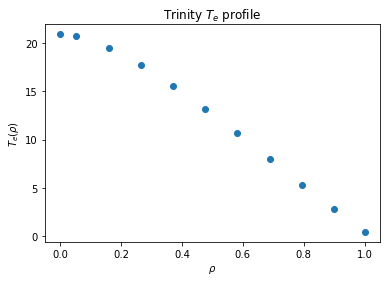

In [69]:
#TODO TODO: DO NOT RUN IF YOU WANT HALEY'S STUFF

def convert(rho1,rho2,prof1):
    prof1fun = PchipInterpolator(rho1,prof1)
    rhoconvfun = PchipInterpolator(rho2,rho1)
    prof2 = prof1fun(rhoconvfun(rho2))
    prof2fun = PchipInterpolator(rho2,prof2)
    #assert np.all(prof1fun(rho1)-prof2fun(rho2) == 0)
    return prof2fun

rho_pol = np.sqrt(gfile['AuxQuantities']['PSI_NORM'])
rho_tor = np.sqrt(gfile['AuxQuantities']['PHI_NORM'])
print(rho_pol[-1])
print(rho_tor[-1])
#with open('log_trinity.npy', 'rb') as f:#'NTARC_zeta_iter1b_ray_EQDSK.npy', 'rb') as f:
#log_trinity_n180.npy
with open('log_trinity_Ip88.npy', 'rb') as f:  #'transport_iter1b_new.npy' 'log_trinity_hires.npy' 'log_trinity_Ip88.npy'
    data = np.load(f, allow_pickle=True).tolist()
#data = np.load('NTARC_zeta_iter1b_ray_EQDSK.npy', allow_pickle=True).tolist()
print(data.keys())
time = np.array( data['time'  ] )
#tags = data['species_tags']
#print(data['p_e'][-1].shape[0])
print('---')
print(data['grid'])
T_e = data['p_e'][-1]/data['n_e'][-1] #data['T_e'][-1]
trinity_rho = data['grid']['rho_axis']
print('-----*-')
print(trinity_rho)
trinity_rho = np.append(np.array([0]), trinity_rho)
trinity_rho = np.append(trinity_rho, np.array([1]))
#trinity_rho = np.array([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
#trinity_rho = np.linspace(0, 1, 5)
T_e = np.append(np.array([T_e[0]*1.01]), T_e)
T_e = np.append(T_e, np.array([0.435]))
plt.scatter(trinity_rho, T_e)
#plt.plot(manta.rho, manta.Te_prof)
plt.ylabel(r'$T_e(\rho)$')
plt.xlabel(r'$\rho$')
plt.title(r'Trinity $T_e$ profile')
print(trinity_rho)

# T_i
T_i = data['p_D'][-1]/data['n_D'][-1] #data['T_e'][-1]
T_i = np.append(np.array([T_i[0]*1.01]), T_i)
T_i = np.append(T_i, np.array([0.435]))

# new stuff for pressure profile matching

pcore = data['p_e'][-1] + data['p_D'][-1]  # right now, D includes T 
pcore = np.append(np.array(pcore[0]*1.01), pcore)
pcore = np.append(pcore, np.array([0]))
pcore = pcore*1e3*1.6e-19*1e20


#------------------------------------------------------------
# NEW SECTION: carfully change trinity_rho, which is rho_tor, to rho_pol, 
# as is used in the rest of the script

# get the trinity poloidal rho
tor_to_pol = PchipInterpolator(rho_tor, rho_pol)
trinity_rho_pol = tor_to_pol(trinity_rho) 
print(trinity_rho_pol)

convert_Tetor_to_Tepol = convert(trinity_rho, trinity_rho_pol, T_e)
convert_Titor_to_Tipol = convert(trinity_rho, trinity_rho_pol, T_i)
convert_pcoretor_to_pcorpol = convert(trinity_rho, trinity_rho_pol, pcore)

T_e = convert_Tetor_to_Tepol(trinity_rho)
T_i = convert_Titor_to_Tipol(trinity_rho)
pcore = convert_pcoretor_to_pcorpol(trinity_rho)


# rhocore = trinity_rho#np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# rhopcore = np.array([0.2,0.4,0.6,0.8])
# psicore = rhocore**2
# psipcore = np.array([(psicore[i+1]+psicore[i])/2 for i in range(len(psicore)-1)])
# TODO: ^^  


#ppcore_trinity = -1/2/rhopcore*1.6e4*(data['aLpe'][-1]/a*np.interp(psipcore,psicore,data['pe'][-1])+data['aLpi'][-1]/a*np.interp(psipcore,psicore,transport['pi'][-1]))
# ncore = data['n'][-1]
# Tecore = data['pe'][-1]/ncore
# Ticore = data['pi'][-1]/ncore

In [10]:
jjj = 1e3*1.6e-19*1e20
plt.plot(data['grid']['rho_axis'], data['p_e'][-1])
plt.plot(trinity_rho, pcore/jjj)

NameError: name 'data' is not defined

Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.
Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


  sauter_bootstrap: extracting data from gfiles...
TRINITY CALLED


Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.
Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


  sauter_bootstrap: extracting data from gfiles...
Ip =  8895022.195922263
Ip2 =  9999063.55
Ip3 =  8799788.460000006
trinity
[11092649.93692913  9061693.50451543  8333034.29271164  7793314.6814547
  7348227.17871088  6961406.91747144  6614978.20298612  6301492.11488477
  6014280.89540676  5748234.46566948  5499190.60057036  5270163.7937797
  5060267.98690825  4866165.13886023  4684960.72097521  4516434.94183983
  4358244.71328787  4209879.46292395  4069683.18624711  3936832.29505091
  3811485.40999686  3690803.88558296  3575391.46723107  3464701.9004675
  3357961.01948723  3255157.79555621  3156801.07605666  3060838.38761766
  2969494.95154069  2880889.40301911  2794841.65964076  2712009.02555842
  2632073.08614471  2554983.38262835  2481652.14414811  2411824.44517234
  2345042.28198834  2280990.94708069  2219906.71872774  2161585.22924292
  2105321.79448863  2051507.95485508  2000085.54678165  1950388.32882185
  1902565.95077839  1856772.0888751   1812640.22142366  1769715.0829076
  

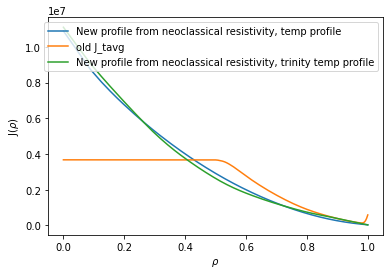

In [11]:
# New area for creating a current profile from a temp and rho profile 
from scipy import interpolate

def get_Jtor_from_T2(tokamak, trinity_Te, trinity_rho, trinity_Ti):
    """
    tokamak: tokamak object from Sam's loop voltage code 
    return: C/neoEta, where C is integration constant to give flux surface averaged integral of Ip
    """
    rho = tokamak.rho
    #temp_prof_func = interpolate.interp1d(trinity_rho, trinity_Te, 'cubic') # create a new temp profile that has the 
                                                              # correct number of indicies to match 
                                                              # tokamak.rho
    temp_prof_func = interpolate.PchipInterpolator(trinity_rho, trinity_Te) # create a new temp profile that has the 
                                                          # correct number of indicies to match 
                                                          # tokamak.rho
    temp_prof_interped =  temp_prof_func(rho)        # call said interpolated function 
    
    timp_prof_func = interpolate.PchipInterpolator(trinity_rho, trinity_Ti) # create a new temp profile that has the 
                                                          # correct number of indicies to match 
                                                          # tokamak.rho
    timp_prof_interped =  timp_prof_func(rho)        # call said interpolated function 
    tokamak.set_trinity_Te_prof(temp_prof_interped)  # use class method to load up this profile 
    tokamak.prof_type='trinity'                      # update profile type. For now, only overwrites 
    tokamak.init_profs()                             #   the Te profile 
    R = tokamak.gfile['fluxSurfaces']['geo']['R']    # not used rn. E goes as 1/R, but need flux surface variables
    neoEta = tokamak.neoEta_prof  
    # Find integration constant to conserve the Ip total current. Note chease redoes this so
    # this is not actually critical for the output profile. 
    C = tokamak.gfile['CURRENT']/integrate.cumtrapz((1/(neoEta*tokamak.R_0)), tokamak.area_cross)[-1]
    return C/(tokamak.R_0*neoEta), temp_prof_interped, timp_prof_interped

def get_Jtor_from_T3(tokamak):
    """
    tokamak: tokamak object from Sam's loop voltage code 
    """
    rho = tokamak.rho
    R = tokamak.gfile['fluxSurfaces']['geo']['R']
    neoEta = tokamak.neoEta_prof #TODO: should replace this with using the trinity temp profile 
    C = tokamak.gfile['CURRENT']/integrate.cumtrapz((1/(neoEta*tokamak.R_0)), tokamak.area_cross)[-1]
    return C/(tokamak.R_0*neoEta)

manta = tokamak()
manta.eqdsk_name = 'gMANTA_iter2_Ip88_k14' #'gMANTA_Ip8-7_k1-40' #'gMANTA_iter2_Ip88_k14'#'gNARC_k14d05R455a120' #'gNTARC_paper' #'gNTARC3'
manta.get_eqdsk_info()
manta.init_profs()
Jnew = get_Jtor_from_T3(manta)
Jnew_trinity, Tnew_trinity, Tinew_trinity = get_Jtor_from_T2(manta, T_e, trinity_rho_pol, T_i)
#Jnew = Jnew*(max(manta.J_tavg)/max(Jnew))
#print(manta.gfile['fluxSurfaces']['geo']['R'])
#print('--')
#print(manta.rho)

plt.plot(manta.rho, Jnew, label='New profile from neoclassical resistivity, temp profile')
plt.plot(manta.rho, manta.J_tavg, label='old J_tavg')
plt.plot(manta.rho, Jnew_trinity, label='New profile from neoclassical resistivity, trinity temp profile')
plt.legend()
plt.ylabel(r'J($\rho$)')
plt.xlabel(r'$\rho$')
Ip = integrate.cumtrapz(manta.J_tavg, manta.area_cross)[-1]
Ip3 = integrate.cumtrapz(Jnew, manta.area_cross)[-1]
Ip2 = gfile['CURRENT']
print('Ip = ', Ip)
print('Ip2 = ', Ip2)
print('Ip3 = ', Ip3)
print(manta.prof_type)
print(Jnew_trinity)
print(manta.eqdsk_name)
np.save('J_new_trinity.npy', Jnew_trinity)

In [12]:
# pressure profile fitting area
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d


def sech(x):
    return 1/np.cosh(x)

def tanh_matcher(x, y2, x2, y1, x1, alpha, amin, amax, diagnostic_flag):
    """
    x: x-axis variable. Must be >= x2
    x1: x-value of first point to match to
    x2: x-value of second point to match to (x2 must be > x1)
    y1: y-value of first point to match to
    y2: y-value of second point to match to
    alpha: location of tanh curvature switch relative to x2 (must be posotive)
    amin: guess for minimum slope
    amax: guess for maximum slope
    diagnostic_flag: True will show plots for finding solution, False will hide plots
    """
    if x[-1] < x2:
        print('Error: using x value below tanh fitted function range')
    elif x2 < x1:
        print('Error: x2 must be greater than x1')
    elif y2 > y1:
        print('Error: this function only works for negative slope')
    
    slope = (y2 - y1)/(x2-x1)
    value = y2
    print(slope)
    alpha2 = alpha-x2 # shift to center on x2 instead of zero
    print('alpha2', alpha2)
    a_array = np.linspace(amin, amax, int(1e6))
    d1 = value/(1-np.tanh(a_array*x2 - alpha2))
    d2 = -slope/(a_array*sech(alpha2 - a_array*x2)**2)
    # Solve for intersection
    imin = np.where(np.abs(d2 - d1) == min(np.abs(d2 - d1)))
    if diagnostic_flag:
        ax3.plot(a_array, d1)
        ax3.plot(a_array, d2, 'r--')
        ax3.scatter(a_array[imin], d2[imin], marker='*', color='red')
    
    d = d2[imin]
    a = a_array[imin]
    
    return -d*np.tanh(a*x - alpha2) + d
 
def tanh_matcher_2_0(x, y2, x2, y1, x1, R, n, d, b, hmin, hmax, diagnostic_flag):

    """

    x: x-axis variable. Must be >= x2

    x1: x-value of first point to match to

    x2: x-value of second point to match to (x2 must be > x1)

    y1: y-value of first point to match to

    y2: y-value of second point to match to

    alpha: location of tanh curvature switch relative to x2 (must be posotive)

    amin: guess for minimum slope

    amax: guess for maximum slope

    diagnostic_flag: True will show plots for finding solution, False will hide plots

    """

    if x[-1] < x2:

        print('Error: using x value below tanh fitted function range')

    elif x2 < x1:

        print('Error: x2 must be greater than x1')

    elif y2 > y1:

        print('Error: this function only works for negative slope')

    S = (y2 - y1)/(x2-x1)

    P = y2

    print(S)

    R2 = R+x2 # shift to center on x2 instead of zero

    print('R2', R2)

    h_array = np.linspace(hmin, hmax, int(1e6))

    m1 = ((P - b) - (h_array/2)*(np.tanh((R2 - x2)/d)+1))/(R2 - x2 -d)**n

    m2 = -(S + h_array/(2*d)*(sech((R2-x2)/d))**2) / (n*(R2- x2 - d)**(n-1))

    # Solve for intersection

    imin = np.where(np.abs(m2 - m1) == min(np.abs(m2 - m1)))

    if diagnostic_flag:

        plt.plot(h_array, m1)

        plt.plot(h_array, m2, 'r--')

        plt.scatter(h_array[imin], m2[imin], marker='*', color='red')
        
    m = m2[imin]

    h = h_array[imin]
    
    return b + (h/2)*(np.tanh((R2-x)/d) + 1) + m* np.abs(R2 - x -d )**n * np.heaviside(R2-x-d, 0)
   





129
psicore.shape(): (162,)
pcore.shape(): (162,)
-1746038.9513896268
R2 0.9859705453537526


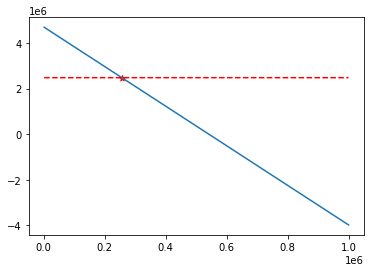

In [13]:
a = 1.2 #[m]
print(manta.rho.shape[0])
psi_norm = manta.rho**2
psicore = trinity_rho_pol**2
deg = 5
paxis = pcore[0]
psi_norm2 = psi_norm[:np.argmin(np.abs(psi_norm-0.7**2))]
psi_norm3 = psi_norm[np.argmin(np.abs(psi_norm-0.7**2)):]
rho3 = np.sqrt(psi_norm3)
rho2 = np.sqrt(psi_norm2)
print(f'psicore.shape(): {psicore.shape}')
print(f'pcore.shape(): {pcore.shape}')
f = interp1d(psicore,pcore,'cubic')
pressure2 = f(psi_norm2)


alpha = 50
hmin = 1e3
hmax = 1e6
diagnostic_flag = True
R = 0.29
n = 1.65 #TODO: this was here
d = 0.02
b = 1.2e3
# alpha = 50
# hmin = 1e3
# hmax = 1e6
# diagnostic_flag = True
# R = 0.23
# n = 6
# d = 0.02
# b = 1.2e3


### Interpolating the pedestal region
pped = tanh_matcher_2_0(rho3, pressure2[-1], rho2[-1], pressure2[-2], rho2[-2], R, n, d, b, hmin, hmax, diagnostic_flag)


pressure2 = np.concatenate([pressure2,pped])
psi_norm2 = np.concatenate([psi_norm2, psi_norm3])

factor1 = 1e3*1.6e-19*1e20
np.save('pressure2.npy', pressure2/factor1)
np.save('pressure_rho', trinity_rho)

pressure_trin_units = pressure2 / factor1

pcore = 111.56293923721103
psep = 3.2313907929858


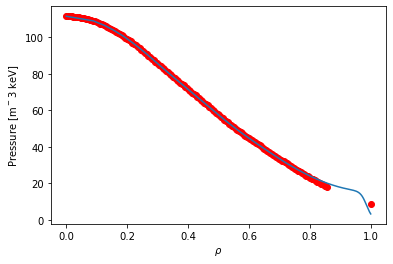

In [14]:
plt.plot(np.sqrt(psi_norm), pressure_trin_units)
#plt.plot(psi_norm, pressure_trin_units)
plt.scatter(np.sqrt(psicore), pcore/(factor1), color='red')
plt.ylabel(r'Pressure [m$^-3$ keV]')
plt.xlabel(r'$\rho$')
print(f'pcore = {pressure_trin_units[0]}')
print(f'psep = {pressure_trin_units[-1]}')

# get Hailey the pressure (density) at 0.9, 0.8, 0.85 
# we need to rerun the blue loop 

# pressure, new eqdsk, new density 
# what are the trinity boundary conditions (density, temp) 

In [17]:
# fit the curve to the data in the form of the density profile function 
from scipy.optimize import curve_fit
%matplotlib inline
#Tnew_trinity, Tinew_trinity

idx_09 = np.argmin(np.abs(np.sqrt(psi_norm) - 0.9))
n_proff = pressure_trin_units / (Tnew_trinity + Tinew_trinity)

#--------------------------
# getting ni and ne seperatly 
n_proff_e = n_e
print(len(n_proff_e)) 

#--------------------------

#n_lineavg = 1.30#np.average(n_proff)
print(f'Line Average Density wrong: {np.average(n_proff)}')

#n_edge = n_proff[idx_09]

def n_profile(rho, alpha1, alpha, n_lineavg, n_edge):
    n_prof = (1 - rho**alpha1)**alpha
    return (n_lineavg - n_edge) / np.average(n_prof) * n_prof + n_edge


popt, pcov = curve_fit(n_profile, np.sqrt(psi_norm)[:idx_09], n_proff[:idx_09])

rho_array = np.sqrt(psi_norm)
rho_array_09 = rho_array[:idx_09]

n_fit = n_profile(rho_array_09, popt[0], popt[1], popt[2], popt[3])
plt.plot(rho_array_09, n_fit)
plt.scatter(rho_array[:idx_09], n_proff[:idx_09])

alpha1 = popt[0]
alpha = popt[1]
#print(n_profile(np.linspace(0, 1, 10), popt[0], popt[1]))
# print(n_fit[0])
# print(rho_array_09[0])
# print(np.linspace(0, 1, 10))
print(f'alpha1: {alpha1}, alpha:  {alpha}')

NameError: name 'psi_norm' is not defined

Text(0.5, 0, '$\\rho_{pol}$')

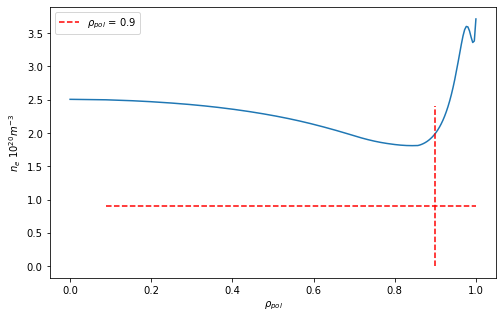

In [16]:
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(5)
plt.plot(rho_array, pressure_trin_units/((Tnew_trinity + Tinew_trinity)))
plt.plot(rho_array, rho_array*0.9/rho_array, color='red', linestyle='--')
plt.vlines(0.9, ymin=0, ymax=2.4, linestyles='dashed', colors='red', label=r'$\rho_{pol}$ = 0.9')
plt.legend()
plt.ylabel(r'$n_{e}$ $10^{20} m^{-3}$')
plt.xlabel(r'$\rho_{pol}$')

In [17]:
#TODO Only run if Haley option is chosen 
Tedge = (T_e[-1] + T_i[-1]) / 2
T_core = (T_e[0] + T_i[0]) / 2
p_core = pcore[0]/factor1
pedge = pcore[-1]/factor1


ne_core = ne_Hal[0]
ne_edge = 0.9e20 #TODO: update this


In [37]:
#TODO: only run if Trinity option is run  
trinity_rho
Tedge = (T_e[-1] + T_i[-1]) / 2
T_core = (T_e[0] + T_i[0]) / 2
p_core = pcore[0]/factor1
pedge = pcore[-1]/factor1

p_e = data['p_e'][-1]
pe_0 = 1.01*p_e[0]
ne_core = pe_0/T_e[0]
ne_edge = 0.9e20 #TODO: update this
T_core

NameError: name 'data' is not defined

In [18]:
n_0 = n_fit[0]
n_90 = n_fit[-1]
print(n_0)
print(n_90)

alphas_n0_n09 = np.array([alpha1, alpha, n_0, n_90])
export_dict = {'pressure_profile': (pressure2/factor1), 
               'pressure_rho': np.sqrt(psi_norm), 
               'alpha1_alpha_n0_n09':alphas_n0_n09,
               'J_profile': Jnew_trinity,
               'T_core_keV': T_core,
               'T_sep_keV': Tedge,
               'ne20_core': ne_core,
               'ne20_sep': ne_edge}
np.save('iteration1_dict.npy', export_dict, allow_pickle=True)
# export_dict = {'pressure_profile': (pressure2/factor1), 
#                'pressure_rho': trinity_rho, 
#                'alpha1_alpha_n0_n09':alphas_n0_n09,
#                'J_profile': Jnew_trinity,
#                'T_core_keV': T_core,
#                'T_sep_keV': Tedge,
#                'ne20_core': ne_core,
#                'ne20_sep': ne_edge}
# np.save('iteration1_dict.npy', export_dict, allow_pickle=True)

with open('nprofile.txt','w') as f:
    txt = f'alpha1: {alpha1}\nalpha: {alpha}\nn0: {n_0}\nn09: {n_90}'
    f.write(txt)

2.4614602770690075
1.829576725266213


In [21]:
with open('iteration1_dict.npy', 'rb') as f:  #'transport_iter1b_new.npy' 'log_trinity_hires.npy'
    load = np.load(f, allow_pickle=True).tolist()
    
load.keys()

dict_keys(['pressure_profile', 'pressure_rho', 'alpha1_alpha_n0_n09', 'J_profile', 'T_core_keV', 'T_sep_keV', 'ne20_core', 'ne20_sep'])

In [22]:
print(load['pressure_profile'].shape[0])
print(load['J_profile'].shape[0])
print(load['alpha1_alpha_n0_n09'])
print(load['pressure_rho'].shape[0])
print(np.sqrt(psi_norm).shape[0])

129
129
[4.1481772  6.25543966 2.46146028 1.82957673]
129
129


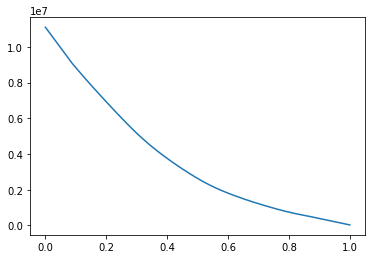

In [23]:
plt.plot(load['pressure_rho'], load['J_profile']) 

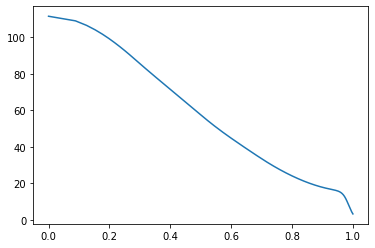

In [24]:
plt.plot(load['pressure_rho'], load['pressure_profile']) 